# Analyzing consolidated_csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("consolidated_csv.csv")
print(df.info())

top25 = [
    "CWE-79", "CWE-787", "CWE-89", "CWE-352", "CWE-22", "CWE-125", "CWE-78", "CWE-416",
    "CWE-862", "CWE-434", "CWE-94", "CWE-20", "CWE-77", "CWE-287", "CWE-269", "CWE-502",
    "CWE-200", "CWE-863", "CWE-918", "CWE-119", "CWE-476", "CWE-798", "CWE-190", "CWE-400", "CWE-306"
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Project_name        73 non-null     object
 1   Tool_name           73 non-null     object
 2   CWE_ID              73 non-null     object
 3   Number of Findings  73 non-null     int64 
 4   Is_In_CWE_Top_25    73 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.0+ KB
None


In [3]:
# Get the set of unique CWE IDs detected by each tool
 
tool_cwe = df['CWE_ID'].groupby(df['Tool_name']).apply(set).to_dict()
print(tool_cwe)


{'codeql': {'CWE-571', 'CWE-315', 'CWE-088', 'CWE-209', 'CWE-022', 'CWE-116', 'CWE-020', 'CWE-772', 'CWE-390', 'CWE-295', 'CWE-312', 'CWE-581', 'CWE-073', 'CWE-079', 'CWE-036', 'CWE-095', 'CWE-685', 'CWE-561', 'CWE-665', 'CWE-078', 'CWE-396', 'CWE-099', 'CWE-094', 'CWE-570', 'CWE-584', 'CWE-628', 'CWE-563', 'CWE-532', 'CWE-497', 'CWE-359', 'CWE-023', 'CWE-117'}, 'semgrep': {'CWE-522', 'CWE-78', 'CWE-798', 'CWE-939', 'CWE-319', 'CWE-79', 'CWE-116', 'CWE-353', 'CWE-706', 'CWE-295', 'CWE-95', 'CWE-1333', 'CWE-502', 'CWE-327', 'CWE-89'}, 'snyk': {'CWE-798', 'CWE-79', 'CWE-942', 'CWE-916', 'CWE-611', 'CWE-23', 'CWE-295', 'CWE-89', 'CWE-547', 'CWE-346'}}


In [4]:
# Compute Top 25 CWE coverage (%) at the tool level.

top25_set = set(top25)
coverage = {}

for tool, cwes in tool_cwe.items():
    covered = len(top25_set & cwes)
    total = len(cwes)
    coverage_pct = (covered / total * 100) if total > 0 else 0
    coverage[tool] = coverage_pct
    print(f"{tool}:")
    print(f"  Unique CWE IDs found: {total}")
    print(f"  Top 25 CWE IDs found: {covered}")
    print(f"  Top 25 CWE Coverage: {coverage_pct:.2f}%\n")

print("Summary Table:")
print("Tool\tUnique_CWE\tTop25_CWE\tCoverage(%)")
for tool in coverage:
    total = len(tool_cwe[tool])
    covered = len(top25_set & tool_cwe[tool])
    print(f"{tool}\t{total}\t\t{covered}\t\t{coverage[tool]:.2f}")

codeql:
  Unique CWE IDs found: 32
  Top 25 CWE IDs found: 0
  Top 25 CWE Coverage: 0.00%

semgrep:
  Unique CWE IDs found: 15
  Top 25 CWE IDs found: 5
  Top 25 CWE Coverage: 33.33%

snyk:
  Unique CWE IDs found: 10
  Top 25 CWE IDs found: 3
  Top 25 CWE Coverage: 30.00%

Summary Table:
Tool	Unique_CWE	Top25_CWE	Coverage(%)
codeql	32		0		0.00
semgrep	15		5		33.33
snyk	10		3		30.00


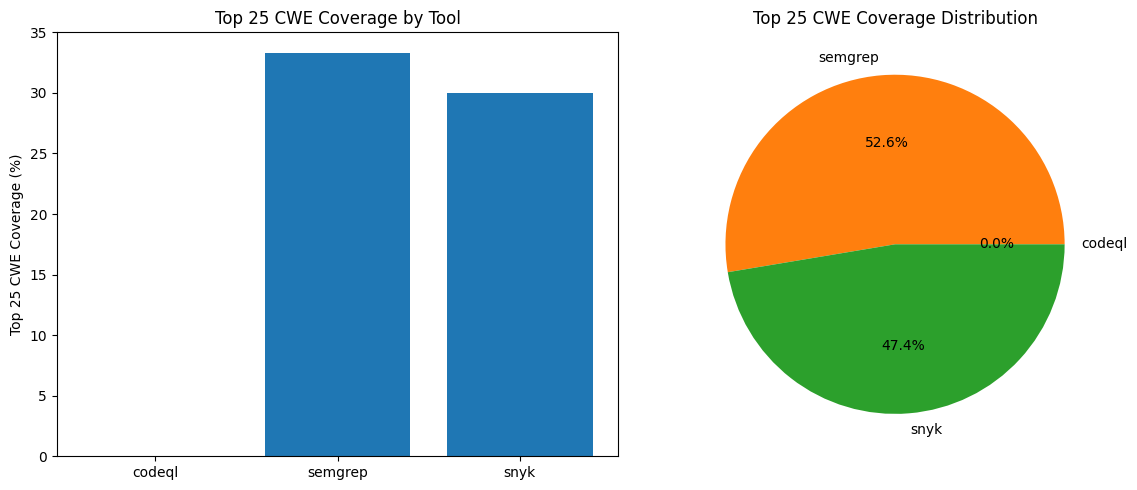

In [5]:
# Visualization of Top 25 CWE coverage by tool

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
axs[0].bar(coverage.keys(), coverage.values())
axs[0].set_ylabel("Top 25 CWE Coverage (%)")
axs[0].set_title("Top 25 CWE Coverage by Tool")

# Pie chart
axs[1].pie(coverage.values(), labels=coverage.keys(), autopct='%1.1f%%')
axs[1].set_title("Top 25 CWE Coverage Distribution")

plt.tight_layout()
plt.show()

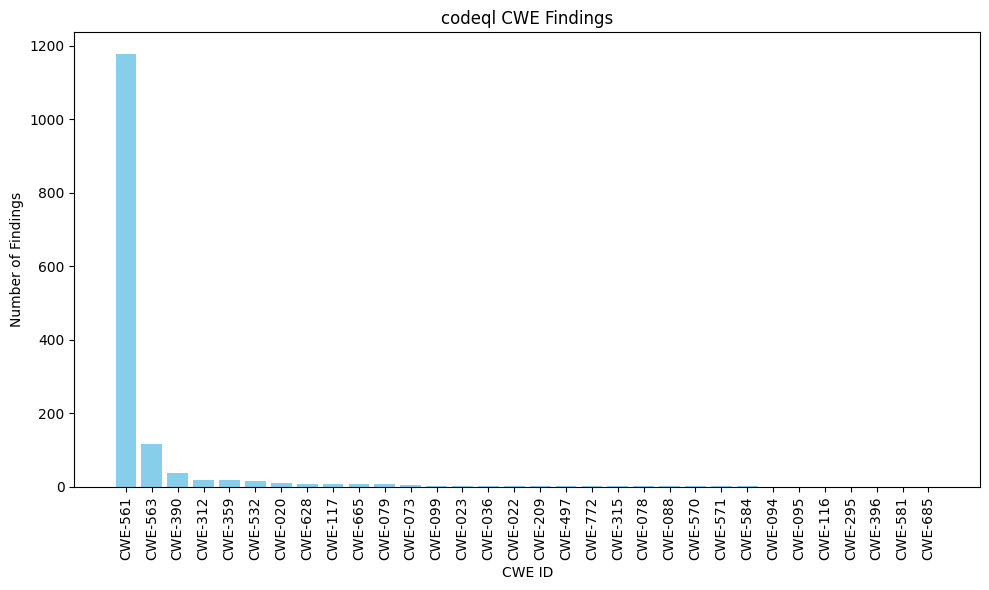

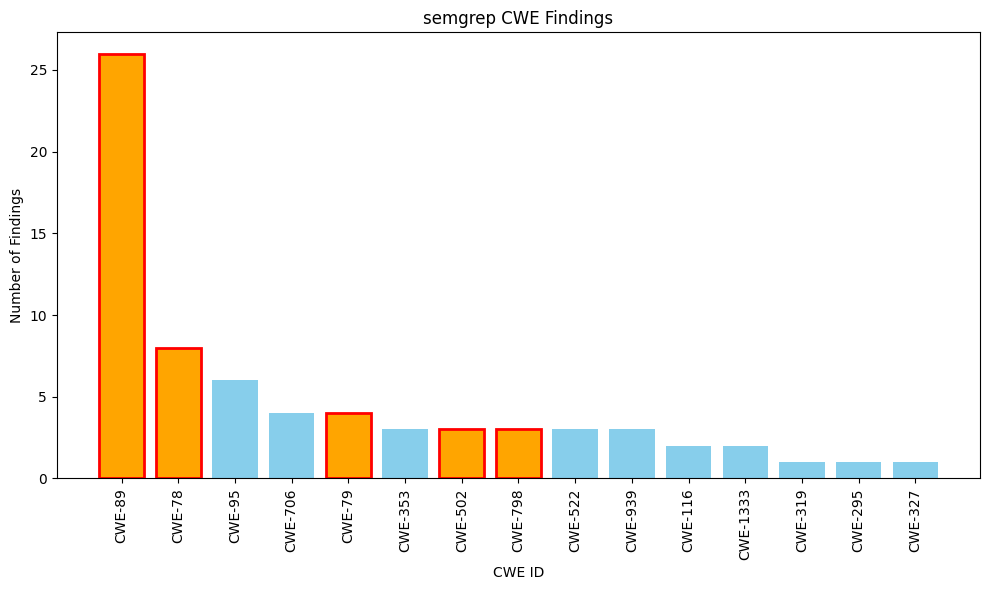

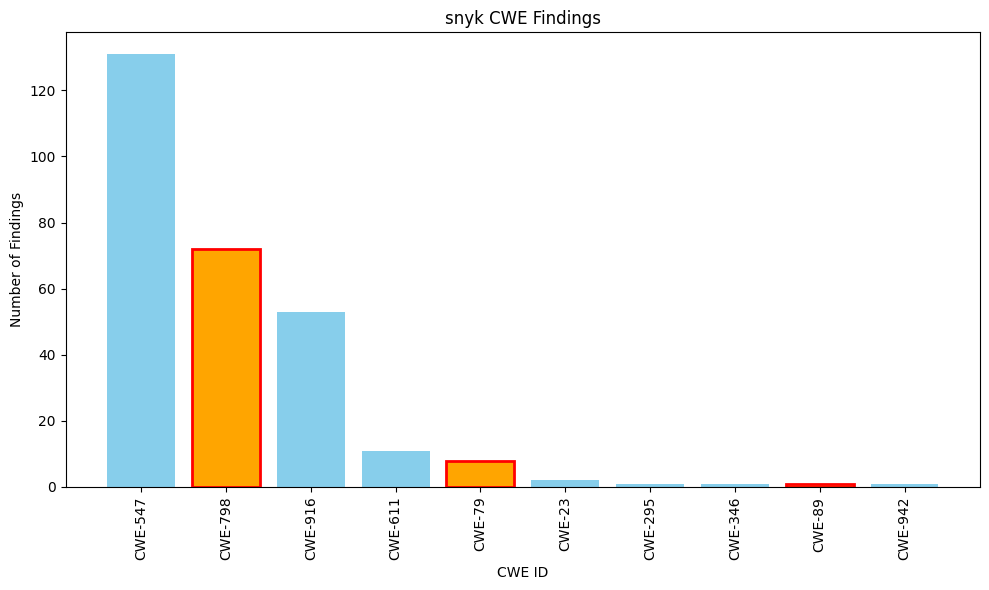

In [6]:
# Toolwise bar charts: Number of Findings for each CWE detected by each tool, highlighting Top 25 CWEs

for tool in df['Tool_name'].unique():
    df_tool = df[df['Tool_name'] == tool]
    cwe_counts_tool = df_tool.groupby('CWE_ID')['Number of Findings'].sum().sort_values(ascending=False)
    is_top25_tool = cwe_counts_tool.index.isin(top25_set)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cwe_counts_tool.index, cwe_counts_tool.values, color=['orange' if t else 'skyblue' for t in is_top25_tool])
    for idx, bar in enumerate(bars):
        if is_top25_tool[idx]:
            bar.set_edgecolor('red')
            bar.set_linewidth(2)
    plt.title(f"{tool} CWE Findings")
    plt.xlabel("CWE ID")
    plt.ylabel("Number of Findings")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [7]:
# Pairwise Agreement (IoU) Analysis

from itertools import product

tools = list(tool_cwe.keys())
iou_matrix = pd.DataFrame(index=tools, columns=tools, dtype=float)

for t1, t2 in product(tools, repeat=2):
    set1, set2 = tool_cwe[t1], tool_cwe[t2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    iou = intersection / union if union else 0.0
    iou_matrix.loc[t1, t2] = iou

print("Pairwise IoU Matrix:")
print(iou_matrix)

Pairwise IoU Matrix:
           codeql   semgrep      snyk
codeql   1.000000  0.044444  0.024390
semgrep  0.044444  1.000000  0.190476
snyk     0.024390  0.190476  1.000000


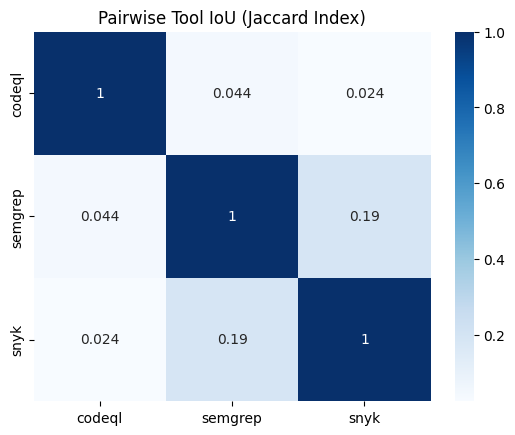

In [8]:
# Plotting the heatmap of IoU matrix

sns.heatmap(iou_matrix, annot=True, cmap="Blues")
plt.title("Pairwise Tool IoU (Jaccard Index)")
plt.show()

**How to read the matrix:**
- Diagonal values (all 1): Each tool compared to itself, so the overlap is 100%.
- Off-diagonal values: These represent the ratio of shared CWE IDs to the total unique CWE IDs found by both tools.


**Interpretation:**
- CodeQL vs Semgrep (0.044) and CodeQL vs Snyk (0.024):
    - Very low overlap. CodeQL finds mostly different CWEs compared to Semgrep and Snyk.
- Semgrep vs Snyk (0.19):
    - Higher overlap than with CodeQL, but still only about 19%. Semgrep and Snyk share more CWEs, but most of their findings are still unique to each tool.


Overall, the tools have low similarity in the types of vulnerabilities (CWEs) they detect. This suggests that each tool covers different aspects of security and using multiple tools can help achieve broader coverage.